In [1]:
# ISRM paper excavation depth analysis

# 


In [1]:
import matplotlib.pyplot as plt
import random
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from random import randint
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn import svm
import os.path
# import pydot
# import graphviz
import numpy as np
from keras.models import Sequential
from sklearn.svm import SVR
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers, utils, backend as K
from keras.layers import Activation, Dense
import pandas as pd
import scikeras
from scikeras.wrappers import KerasRegressor
# from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Perceptron
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Collecting data from RS2 result files

In [2]:
#inputs according to size of MC analysis
l=800 # number of RS2 models (samples)
nos=l # number of samples for each variable




no_cons=[] # non-converging models
con_steps=[] # number of stages until non-convergence
headerName=['phase2']

for j in range(l):
    if j<9: # adjust according to number of digits nos
        
        cc='00'+str(j+1)+ '.log'
       
    if j>=9 and j<99:     
        
        cc='0'+str(j+1)+ '.log'
        
    if j>=99 and j<999:
        
        cc=str(j+1)+ '.log'
        
    if j>=999 and j<l+1:
       
        cc=str(j+1)+ '.log'
      
    path1=r'C:\Users\amichai\Desktop\python_practice\RS2\isrm_1\\'+cc
    
    
    con=pd.read_fwf(path1, delimiter = ' ') # convergence file
    con=con.dropna(axis=1)
    # checking for non-convergence
    check = np.column_stack([con[col].astype(str).str.contains("Convergence may not be established", na=False) for col in con])
    
    for k in range(len(check)):
        if any(check[k])==True:
            no_cons.append(j)
            break
            
    
    
    con.columns=headerName
    con_step=con[con['phase2'].str.contains("Model Step")==True]        
    con_steps.append(len(con_step))
    stg=con_steps[j]



In [3]:
# defining Y as max. excavation depth 
no_cons=np.array(no_cons)
all=np.linspace(0,799,800)
convs = np.setdiff1d(all, no_cons) # models that converge

In [4]:

for i in range(len(convs)):
        pp=int(convs[i])
        
        con_steps[pp]=10
        
Y = [x - 2 for x in con_steps] # model stage is larger by 2 than depth due to initial stage

In [5]:
print('re-check effect of truncating 10% from test data set')
print('predict for more narrow and normaly distributed data')


re-check effect of truncating 10% from test data set
predict for more narrow and normaly distributed data


In [6]:
# distribution of non-cnovergence stages
Ypd = pd.DataFrame(Y, columns = ['depth'])
distY=Ypd.value_counts()
distY=distY.reset_index()
distY=distY.rename({0: 'frequency'}, axis='columns')
distY=distY.set_index('depth')

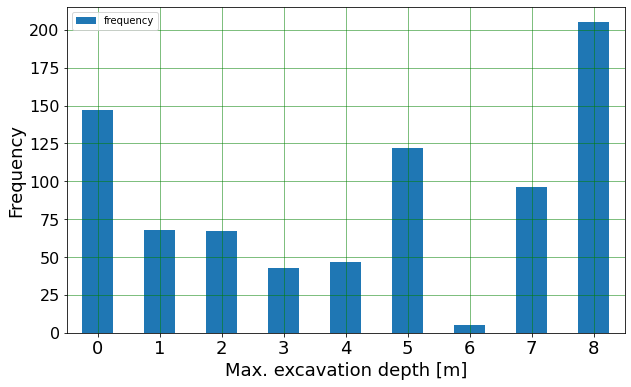

In [7]:

distY=distY.sort_index()
distY.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xticks(rotation=0, fontsize=18)
plt.yticks(rotation=0, fontsize=16)
plt.xlabel('Max. excavation depth [m]', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()

In [8]:
# X2 defined as varied parameters for feature importance
# takes inputs from varsamples and arranges them in X2
d2 = pd.read_fwf (r'C:\Users\amichai\Desktop\python_practice\RS2\isrm_1\varsamples.txt')
nov=7

nos=l # adjust if checking subset of models
X2=np.zeros((l,nov))

for i in range(9,9+l):
    for j in range(nov):
        yy=d2.iloc[i+j*(nos+8),0]
        yy=pd.to_numeric(yy)
        X2[i-9,j]=yy


In [9]:
Xpd = pd.DataFrame(X2, columns = ['E', 'Poisson', 'UCS',
        'GSI_p', 'mi_p', 'GSI_res', 'mi_res'])
Xpd['depth']=Y
Xpd

,E,Poisson,UCS,GSI_p,mi_p,GSI_res,mi_res,depth
0,504.654,0.228050,24.8558,31.3839,7.28489,14.13210,4.36641,7
1,719.337,0.290533,17.2646,30.8608,7.99078,7.72683,4.13025,1
2,800.241,0.256297,27.1679,30.8919,7.26420,9.77096,4.99069,7
3,900.006,0.221586,24.2601,27.3566,9.97809,14.87490,4.27277,3
4,771.279,0.221320,17.9958,42.4615,7.11020,11.68940,4.87851,8
...,...,...,...,...,...,...,...,...
795,717.231,0.212223,13.2386,39.9449,8.86789,8.60210,5.61272,5
796,721.244,0.218369,26.3250,25.1868,7.28050,11.60210,4.72512,3
797,518.387,0.241545,15.5654,42.3528,6.49330,9.76974,4.52620,8
798,895.459,0.280126,27.6928,36.2741,8.35463,14.56110,5.74212,8


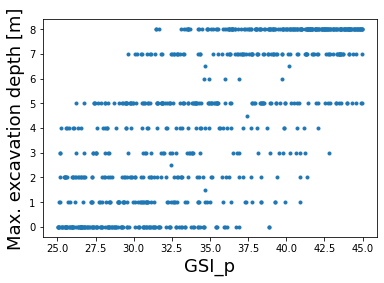

In [10]:

# chenking GSI_p vs. depth
# Xpd['GSI_p']=round(Xpd['GSI_p'])
GSI_to_depth=Xpd.groupby('GSI_p')['depth'].mean()
GSI_to_depth.plot(x='x_col', y='y_col', style='.')
plt.xlabel('GSI_p', fontsize=18)
plt.ylabel('Max. excavation depth [m]', fontsize=18)
x = Xpd['GSI_p'].to_numpy() 
y = Xpd['depth'].to_numpy() 
# m, b = np.polyfit(x,y, 1)
# model = np.polyfit(x, y, 1)
# predict = np.poly1d(model)
# r2_lin=round(r2_score(y, predict(x)),4)
# plt.plot(x, m*x+ b)

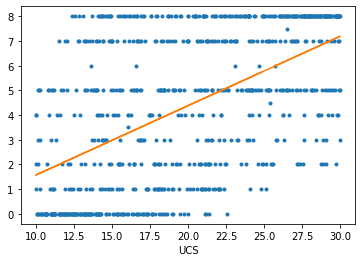

In [11]:
# chenking  UCS vs. depth
# Xpd['UCS']=round(Xpd['UCS'])
UCS_to_depth=Xpd.groupby('UCS')['depth'].mean()
UCS_to_depth.plot(x='x_col', y='y_col', style='.')
x = Xpd['UCS'].to_numpy() 
y = Xpd['depth'].to_numpy() 
m, b = np.polyfit(x,y, 1)
model = np.polyfit(x, y, 1)
predict = np.poly1d(model)
r2_lin=round(r2_score(y, predict(x)),4)
plt.plot(x, m*x+ b)

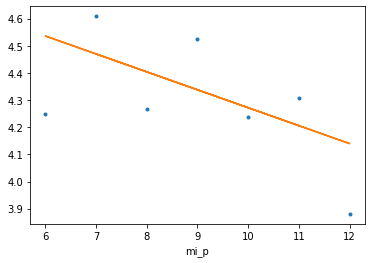

In [12]:
# chenking mi vs depth
Xpd['mi_p']=round(Xpd['mi_p'])
mi_to_depth=Xpd.groupby('mi_p')['depth'].mean()
mi_to_depth.plot(x='x_col', y='y_col', style='.')
x = Xpd['mi_p'].to_numpy() 
y = Xpd['depth'].to_numpy() 
m, b = np.polyfit(x,y, 1)
model = np.polyfit(x, y, 1)
predict = np.poly1d(model)
r2_lin=round(r2_score(y, predict(x)),4)
plt.plot(x, m*x+ b)

In [13]:
# X2=Xpd[Xpd.depth<8]


In [14]:
# Normalization
# scaler = MinMaxScaler()
# X2=scaler.fit_transform(X2)
# X2=scaler.inverse_transform(X2)
# Normalization found to have no impact on score

In [15]:
Y=Xpd['depth']
X2=Xpd.drop(['depth'], axis=1)


# Support Vector Regression

In [16]:
# Support vector machine regression
# Normalization
scaler = MinMaxScaler()

# X2=scaler.inverse_transform(X2)
X_train, X_test, y_train, y_test = train_test_split(X2, Y, test_size=0.2, random_state=42)
X_trainT=scaler.fit_transform(X_train)
X_testT=scaler.fit_transform(X_test)

svr = SVR(kernel="rbf", C=100, gamma="auto", degree=3, epsilon=0.1)
svr.fit(X_trainT, y_train)
# Predict on new data
y_rf = svr.predict(X_testT)
svrscore=svr.score(X_testT, y_test, sample_weight=None)
svrscore

0.918801526057732

In [17]:
RMSE_SVR=(mean_squared_error(y_test, y_rf))**0.5
RMSE_SVR

0.8680252976282686

# Support Vector Classification

In [18]:
scaler = MinMaxScaler()

# X2=scaler.inverse_transform(X2)
X_train, X_test, y_train, y_test = train_test_split(X2, Y, test_size=0.2, random_state=42)
X_trainT=scaler.fit_transform(X_train)
X_testT=scaler.fit_transform(X_test)

svc = svm.SVC()
svc.fit(X_trainT, y_train)
# Predict on new data
y_svc = svc.predict(X_testT)
svcscore=svc.score(X_testT, y_test, sample_weight=None)
svcscore

0.64375

In [19]:
RMSE_SVC=(mean_squared_error(y_test, y_svc))**0.5
RMSE_SVC

1.0428326807307104

# Random Forest Classification

In [33]:
scaler = MinMaxScaler()

# X2=scaler.inverse_transform(X2)
X_train, X_test, y_train, y_test = train_test_split(X2, Y, test_size=0.2, random_state=42)
X_trainT=scaler.fit_transform(X_train)
X_testT=scaler.fit_transform(X_test)
class_rf = RandomForestClassifier(max_depth=80, random_state=123)
class_rf.fit(X_trainT, y_train)
# Predict on new data
y_rf = class_rf.predict(X_testT)
forestscoreC=class_rf.score(X_testT, y_test, sample_weight=None)

forestscoreC

0.675

In [34]:
# RMSE
RMSE_RFC=(mean_squared_error(y_test, y_rf))**0.5
RMSE_RFC

0.8979142498033985

Text(0, 0.5, 'Predicted non-convergence stage #')

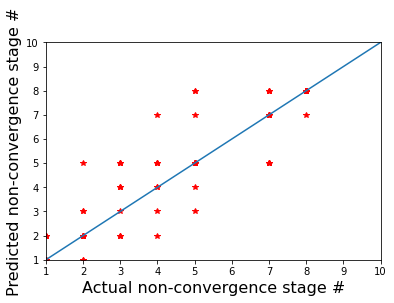

In [35]:
# prediction vs. actual  plot
y_t=y_test
nn=10 # plot boundary
xx=np.linspace(0, nn, len(y_t))
yy=xx
plt.plot(y_t, y_rf, 'r*')
plt.plot(xx, yy)
plt.axis([1, nn, 1, nn])
plt.xlabel("Actual non-convergence stage #", fontsize=16)
plt.ylabel("Predicted non-convergence stage #", fontsize=16)

array([2, 4, 0, 8, 0, 3, 8, 3, 5, 2, 1, 8, 0, 5, 1, 8, 8, 8, 0, 2, 0, 5,
       0, 2, 0, 5, 5, 8, 2, 2, 8, 8, 7, 8, 0, 5, 5, 0, 4, 7, 7, 8, 5, 3,
       8, 8, 8, 0, 5, 8, 2, 2, 5, 8, 5, 5, 8, 5, 0, 0, 8, 5, 8, 1, 2, 5,
       0, 1, 0, 8, 8, 0, 8, 5, 7, 3, 2, 1, 1, 8, 8, 0, 4, 1, 8, 5, 2, 2,
       0, 5, 5, 2, 4, 0, 8, 8, 8, 7, 0, 5, 2, 0, 5, 2, 5, 1, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 0, 5, 2, 5, 5, 0, 7, 2, 8, 8, 8, 4, 7, 5, 2, 2, 7,
       4, 1, 1, 0, 5, 7, 2, 3, 8, 8, 5, 8, 7, 8, 1, 8, 8, 5, 8, 7, 8, 2,
       0, 2, 8, 5, 0, 5], dtype=int64)

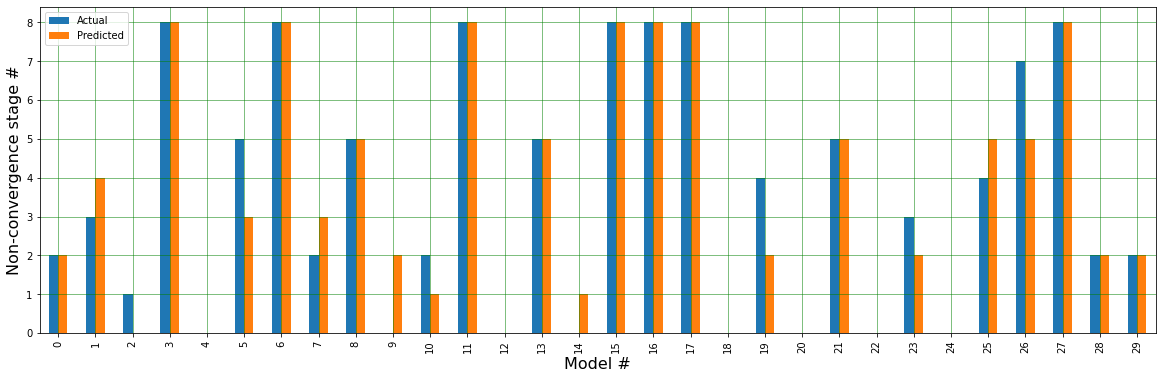

In [39]:
predictions = y_rf
y_test=np.array(y_test)
df_temp2 = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

df_temp2 = df_temp2.head(30)
df_temp2.plot(kind='bar',figsize=(20,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlabel('Model #', fontsize=16)
plt.ylabel('Non-convergence stage #', fontsize=16)
plt.show()

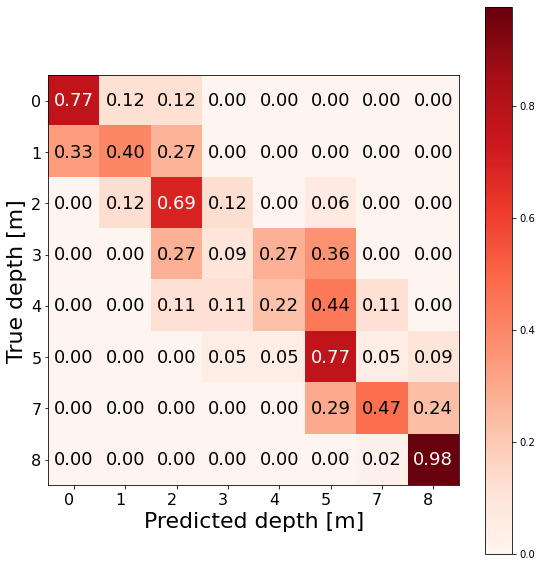

In [73]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

cm = confusion_matrix(y_test, predictions)
classes = unique_labels(y_test, predictions)

# normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot the confusion matrix
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Reds)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm_normalized.shape[1]),
       yticks=np.arange(cm_normalized.shape[0]),
       xticklabels=classes, yticklabels=classes,
       ylabel='True depth [m]',
       xlabel='Predicted depth [m]')
# set the font size of the tick labels and title
ax.tick_params(axis='both', which='major', labelsize=16)

# set the font size of the x and y labels
ax.set_xlabel(ax.get_xlabel(), fontsize=22)
ax.set_ylabel(ax.get_ylabel(), fontsize=22)

# rotate the xtick labels for better visibility
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

# loop over the data and add the annotations
fmt = '.2f'
thresh = cm_normalized.max() / 2.
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        ax.text(j, i, format(cm_normalized[i, j], fmt),
                ha="center", va="center", fontsize=18,
                color="white" if cm_normalized[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

# Random forest resgression

In [29]:
# ML Regression

# Normalization- found unuseful


# X, Y = shuffle(X, Y)
X_train, X_test, y_train, y_test = train_test_split(X2, Y, test_size=0.3, random_state=42)
X_trainT=scaler.fit_transform(X_train)
X_testT=scaler.fit_transform(X_test)

X_trainT=scaler.inverse_transform(X_trainT)
X_testT=scaler.inverse_transform(X_testT)

# Random forest model
regr_rf = RandomForestRegressor(max_depth=80, random_state=123)
regr_rf.fit(X_trainT, y_train)
# Predict on new data
y_rf = regr_rf.predict(X_testT)
forestscoreR=regr_rf.score(X_testT, y_test, sample_weight=None)
forestscoreR

0.9495549307983143

In [30]:
# RMSE
RMSE_RFR=(mean_squared_error(y_test, y_rf))**0.5
RMSE_RFR

0.6787663441862745

Text(0, 0.5, 'Predicted non-convergence stage #')

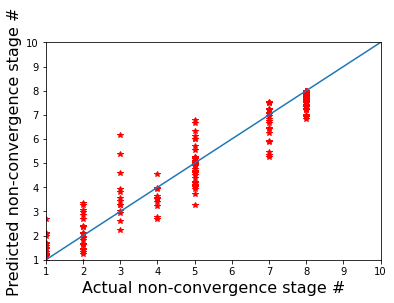

In [31]:
# prediction vs. actual  plot
y_t=y_test
nn=10 # plot boundary
xx=np.linspace(0, nn, len(y_t))
yy=xx
plt.plot(y_t, y_rf, 'r*')
plt.plot(xx, yy)
plt.axis([1, nn, 1, nn])
plt.xlabel("Actual non-convergence stage #", fontsize=16)
plt.ylabel("Predicted non-convergence stage #", fontsize=16)

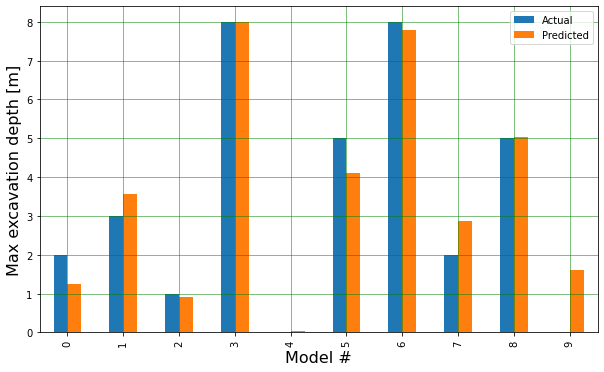

In [32]:
predictions = y_rf
y_test=np.array(y_test)
# predictions, y_test=shuffle(predictions, y_test)
df_temp2 = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

df_temp2 = df_temp2.head(10)
df_temp2.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlabel('Model #', fontsize=16)
plt.ylabel('Max excavation depth [m]', fontsize=16)
plt.show()

# KNeighbors Regression

In [33]:
neigh = KNeighborsRegressor(n_neighbors=5) # neighbors=5 found to be optimal
KNR=neigh.fit(X_trainT, y_train)
y_knn = KNR.predict(X_testT)
RMSE_KNR=(mean_squared_error(y_test, y_knn))**0.5
print(RMSE_KNR)

1.8244633914295643


# KNeighbors Classification

In [34]:
neigh = KNeighborsClassifier(n_neighbors=6)
KNC=neigh.fit(X_trainT, y_train)
y_knc = KNC.predict(X_testT)
RMSE_KNC=(mean_squared_error(y_test, y_knc))**0.5
print(RMSE_KNC)

2.4238399287081647


# Linear regression

In [35]:

X_train, X_test, y_train, y_test = train_test_split(X2, Y, test_size=0.2, random_state=42)
Lreg = LinearRegression().fit(X_train, y_train)
y_Lreg = Lreg.predict(X_test)
linearRscore=Lreg.score(X_test, y_test, sample_weight=None)
linearRscore

0.86096130506976

In [36]:

RMSE_LR=(mean_squared_error(y_test, y_Lreg))**0.5
RMSE_LR

1.135863882060379

In [37]:
# Linear Pearson coefficient for each input parameter
x2=np.array(X2)
y2=np.array(Y)
Pearson=[]
for i in range(7):
    xy=np.zeros((len(x2),2))
    xy[:,0]=x2[:,i]
    xy[:,1]=y2
    xy = pd.DataFrame(xy, columns = ['A','B'])
    xy=xy.corr()
    xy=round(xy,3)
    Pearson.append(xy.iloc[1,0])

Pearson

[0.031, -0.146, 0.544, 0.709, -0.038, 0.071, -0.003]

# Plot of score vs. number of samples

In [38]:
nn=55
initial=50
delta=10
print("max. samples: ", initial+delta*nn)
ForestscoreC=np.zeros(nn)
ForestscoreR=np.zeros(nn)
ForestC_RMSE=np.zeros(nn)
ForestR_RMSE=np.zeros(nn)
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

max. samples:  600


In [39]:

ll=[]

for i in range(nn):
    j=int(initial+delta*i)
    ll.append(j)
    X_train, y_train = shuffle(X_train, y_train)
    X_train1=X_train[0:int(0.8*j),:]
    y_train1=y_train[0:int(0.8*j)]
    X_test1=X_test[0:int(0.2*j),:]
    y_test1=y_test[0:int(0.2*j)]
    # X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.3, random_state=42)
    
    # Random forest model
    regr_rf = RandomForestRegressor(max_depth=80, random_state=123)
    regr_rf.fit(X_train1, y_train1)
    # Predict on new data
    y_rf = regr_rf.predict(X_test1)
    ForestscoreR[i]=regr_rf.score(X_test1, y_test1, sample_weight=None)
    ForestR_RMSE[i]=(mean_squared_error(y_test1, y_rf))**0.5

In [40]:
ll=[]

for i in range(nn):
    j=int(initial+delta*i)
    ll.append(j)
    # X_train, y_train = shuffle(X_train, y_train)
    X_train1=X_train[0:int(0.8*j),:]
    y_train1=y_train[0:int(0.8*j)]
    X_test1=X_test[0:int(0.2*j),:]
    y_test1=y_test[0:int(0.2*j)]
    # X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.3, random_state=42)
    
    # Random forest model
    class_rf = RandomForestClassifier(max_depth=80, random_state=123)
    class_rf.fit(X_train1, y_train1)
    # Predict on new data
    y_rf = class_rf.predict(X_test1)
    ForestscoreC[i]=class_rf.score(X_test1, y_test1, sample_weight=None)
    ForestC_RMSE[i]=(mean_squared_error(y_test1, y_rf))**0.5

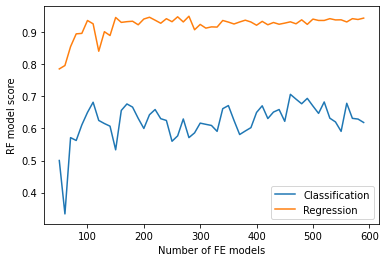

In [41]:
plt.plot(ll, ForestscoreC,label='Classification')
plt.plot(ll, ForestscoreR,label='Regression')
plt.legend(loc='lower right')
plt.xlabel('Number of FE models')
plt.ylabel('RF model score')
plt.rcParams.update({'font.size': 14})
plt.show()

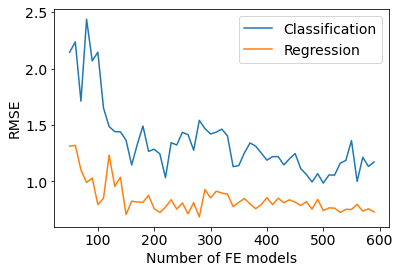

In [42]:
plt.plot(ll, ForestC_RMSE,label='Classification')
plt.plot(ll, ForestR_RMSE,label='Regression')
plt.legend(loc='upper right')
plt.xlabel('Number of FE models')
plt.ylabel('RMSE')
plt.rcParams.update({'font.size': 14})
plt.show()

## Data preparation for feature importance

In [43]:
Xisrm=X2
np.savetxt('Xisrm.txt',Xisrm)
Yisrm=Y
np.savetxt('Yisrm.txt',Yisrm)

In [44]:
# ML feature importance, input parameters against non-converging stage



X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y, test_size=0.3, random_state=42)

# Random forest model
regr_rf = RandomForestRegressor(max_depth=80, random_state=0)
regr_rf.fit(X_train2, y_train2)
# Predict on new data
y_rf = regr_rf.predict(X_test2)
forestscore=regr_rf.score(X_test2, y_test2, sample_weight=None)
forestscore


0.9461825190896286

Text(0, 0.5, 'Feature importance')

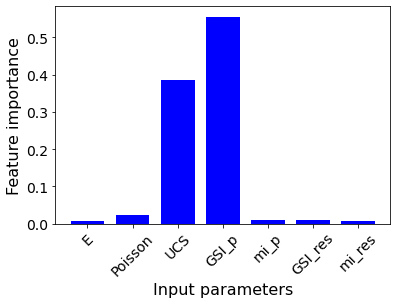

In [45]:

# feature importance
fi=regr_rf.feature_importances_
data = {'E':fi[0], 'Poisson':fi[1], 'UCS':fi[2],
        'GSI_p':fi[3], 'mi_p':fi[4], 'GSI_res':fi[5], 'mi_res':fi[6]}
models = list(data.keys())
values = list(data.values())
plt.bar(models, values, color ='Blue', width = 0.75)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Input parameters", fontsize=16)
plt.ylabel("Feature importance", fontsize=16)

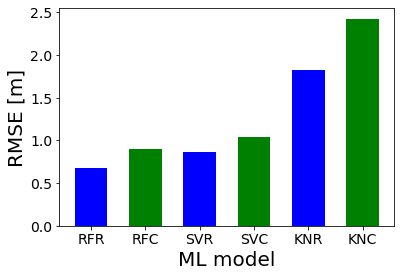

In [47]:
# Model Comparison

data = {'RFR':RMSE_RFR, 'RFC':RMSE_RFC, 'SVR':RMSE_SVR, 'SVC':RMSE_SVC,
       'KNR':RMSE_KNR, 'KNC':RMSE_KNC}
models = list(data.keys())
values = list(data.values())
c=['Blue', 'Green', 'Blue', 'Green', 'Blue', 'Green']
plt.bar(models, values, color =c, width = 0.6)
plt.xlabel("ML model", fontsize=20)
plt.ylabel("RMSE [m]", fontsize=20)
# plt.title("ML model performance", fontsize=16)

plt.show()

# Creating narrow normally distributed data

In [48]:
# ML Regression

# Normalization- found unuseful


# X, Y = shuffle(X, Y)
X_train, X_test, y_train, y_test = train_test_split(Xisrm, Yisrm, test_size=0.3, random_state=42)
# X_trainT=scaler.fit_transform(X_train)
# X_testT=scaler.fit_transform(X_test)

# X_trainT=scaler.inverse_transform(X_trainT)
# X_testT=scaler.inverse_transform(X_testT)

# Random forest model
regr_rf = RandomForestRegressor(max_depth=80, random_state=123)
regr_rf.fit(X_train, y_train)
# Predict on new data
y_rf = regr_rf.predict(X_test)
forestscoreR=regr_rf.score(X_test, y_test, sample_weight=None)
forestscoreR

0.9493812508197562

In [76]:

n=10000 # number of iterations
E2=[]
Poisson2=0.25
UCS2=[]
GSI_p2=[]
mi_p2=9
GSI_res2=5
mi_res2=5
# Xm=np.zeros([n,7])
Xm=[]
# depth2=[]

for i in range(n):
    mu, sigma = 600, 0 # mean and standard deviation
    Em = np.random.normal(mu, sigma)
    mu, sigma = 25,0
    UCSm=np.random.normal(mu, sigma)
    GSI_mean=30
    GSI_range=10
    GSI_pm=GSI_mean-0.5*GSI_range+GSI_range*np.random.random_sample()
    X3=np.array([Em, Poisson2, UCSm, GSI_pm, mi_p2, GSI_res2, mi_res2])
    # X3= {'E':Em, 'Poisson':Poisson2, 'UCS':UCSm,
        # 'GSI_p':GSI_pm, 'mi_p':mi_p2, 'GSI_res':GSI_res2, 'mi_res':mi_res2}
    # X3=scaler.fit_transform([X3])
    # depthm=regr_rf.predict(X3)
    # print(depthm)
    Xm.append(X3)
    E2.append(Em)
    UCS2.append(UCSm)
    GSI_p2.append(GSI_pm)
    # depth2.append(depthm)
depth2=regr_rf.predict(Xm)
depth2.mean()

c:\users\amichai\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


4.379098

In [77]:
distY2=np.round(depth2)
distY2=pd.DataFrame(distY2, columns = ['depth'])
distY2=distY2.groupby(['depth'])['depth'].count()

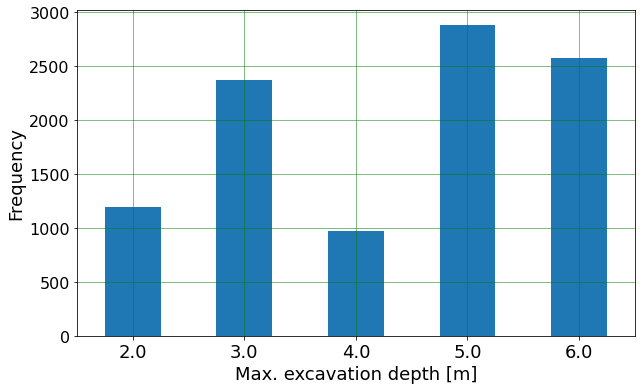

In [78]:
distY2=distY2.sort_index()
distY2.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xticks(rotation=0, fontsize=18)
plt.yticks(rotation=0, fontsize=16)
plt.xlabel('Max. excavation depth [m]', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()

In [ ]:
distY2=distY2.sort_index()
distY2.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xticks(rotation=0, fontsize=18)
plt.yticks(rotation=0, fontsize=16)
plt.xlabel('Max. excavation depth [m]', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()

## Inverse problem

In [24]:
# X, Y = shuffle(X, Y)
GSI_p=X2[:,3]
X_train, X_test, y_train, y_test = train_test_split(GSI_p, X2, test_size=0.3, random_state=42)

# Random forest model
regr_rf = RandomForestRegressor(max_depth=80, random_state=123)
regr_rf.fit(X_train, y_train)
# Predict on new data
y_rf = regr_rf.predict(X_test)
forestscoreR=regr_rf.score(X_test, y_test, sample_weight=None)
forestscoreR

ValueError: Expected 2D array, got 1D array instead:
array=[39.3718 40.6774 44.967  41.6936 38.8639 36.005  38.9213 29.9409 35.0955
 42.5536 25.072  39.2656 25.5933 32.77   44.2975 33.5287 29.5723 42.7398
 35.181  41.9518 42.7245 34.4565 41.2529 37.0878 38.4037 32.1651 33.0251
 34.1806 33.8809 34.208  39.5665 34.23   39.1215 34.9362 35.4898 29.4496
 35.8457 28.8508 30.9462 42.6116 29.3275 25.4785 31.155  32.6205 30.8449
 44.8035 39.7905 34.2654 30.1088 39.7929 26.4228 40.5364 31.1049 33.0868
 40.0267 43.6059 34.368  33.5806 39.1386 25.2313 37.7171 32.8304 28.3021
 30.0667 33.8919 27.3188 25.119  43.7829 41.3335 37.2105 42.5195 29.5412
 30.9987 36.0355 43.5321 26.7798 39.5506 41.9628 44.9335 38.5289 26.1011
 34.678  32.4264 39.113  34.5889 27.3566 26.5406 38.137  28.7031 25.683
 25.9857 26.5723 28.0158 25.9375 40.5675 32.521  36.4383 25.5322 27.6099
 25.0501 35.77   29.17   29.0333 37.772  39.6965 34.3283 31.8264 34.1952
 35.5051 37.2898 28.1544 31.8343 33.8437 41.4391 38.2957 29.4227 44.0014
 43.8726 36.8088 33.0728 32.3989 43.9593 25.8332 30.3609 39.7514 33.4976
 30.8174 44.2438 25.3778 31.5792 42.7892 30.6545 41.0381 44.3402 31.3839
 28.1037 39.0281 32.5356 32.3849 27.2541 26.2439 34.4076 42.6775 31.5072
 26.0431 30.2004 33.0654 37.7049 41.9109 36.7417 35.4129 43.0786 34.3118
 40.5571 33.2034 37.6981 25.9626 34.9106 35.8316 41.5618 35.275  43.5937
 44.8932 38.1083 25.5152 25.0665 35.9787 37.1586 42.3486 26.7548 27.2822
 31.6488 40.23   28.5731 39.29   44.2572 25.9937 42.0971 30.6166 43.316
 25.5896 35.3238 38.466  29.85   30.5165 38.3366 36.4945 39.9388 36.9431
 44.2438 29.8    39.3248 43.8519 39.2564 39.1459 25.3095 40.8885 32.2292
 43.4893 40.6737 28.4651 30.6081 41.9335 26.3935 31.0659 27.7015 33.5452
 30.6301 30.1619 27.533  38.8279 26.3392 37.7622 41.6698 26.6895 32.8872
 29.4496 43.4619 31.2343 41.3439 30.2748 36.9254 27.3444 34.0152 28.1019
 38.8737 29.2714 38.9958 28.3076 39.2106 26.7505 27.2114 26.5778 37.9057
 36.2534 30.7692 42.846  33.1448 37.7158 30.699  25.5469 34.8892 44.8444
 31.6482 39.7691 27.8407 34.6719 36.268  36.4145 41.306  35.4373 27.6148
 28.1477 28.9943 26.709  40.8702 36.6227 37.1421 31.0457 35.9751 28.224
 33.287  40.5113 25.622  31.1403 36.3694 39.3529 32.1023 38.35   38.5228
 30.9584 28.8148 34.2471 43.9319 42.7978 40.3307 41.4074 36.2577 27.2968
 31.7592 31.9582 30.0777 38.9549 28.2313 25.4004 29.38   40.9532 35.3787
 26.3416 26.5778 32.629  29.4826 40.9539 30.0691 30.7759 26.0596 31.9387
 27.8016 44.7467 37.2568 29.8042 37.7335 25.7984 40.0914 29.2018 43.341
 33.5366 31.8661 28.5536 26.7463 42.8527 30.5971 30.4915 32.3794 36.2247
 41.8548 25.5695 29.6205 41.2804 41.6863 28.7965 44.6716 37.3942 38.4977
 27.5019 37.5474 35.4978 44.8511 39.8747 27.3267 40.8275 26.2323 41.7101
 35.0497 28.8087 37.429  32.7639 33.4542 43.3447 35.372  30.1112 32.7572
 33.1301 36.4164 43.8739 33.5586 44.5379 33.9682 43.4637 43.2641 38.0613
 44.5111 29.687  44.0185 38.1376 30.7051 40.2562 28.2954 27.5245 27.3865
 40.3978 34.5767 29.9635 43.4942 36.7985 38.0198 41.3109 43.5614 42.0141
 28.4223 26.5302 30.3285 31.6176 39.8851 26.5558 32.3409 40.927  34.3161
 39.7233 25.6177 30.934  26.4655 37.7311 26.5308 32.5997 30.4445 27.9286
 38.9647 39.7172 39.9852 43.7439 41.9976 43.5162 33.3731 29.0101 25.9925
 28.357  32.607  38.8847 40.7128 27.5715 41.361  36.9218 44.2413 31.8825
 36.0923 26.626  33.5861 31.4675 32.8677 41.8737 26.4777 30.9011 33.0581
 35.4794 42.0305 34.5395 41.1522 32.2829 38.2218 42.0568 42.1093 34.0255
 34.6115 42.1227 38.2823 29.2439 38.5447 44.0924 41.6393 26.803  41.5801
 42.4615 32.7712 41.256  27.2309 44.0826 30.7973 31.7824 34.678  33.7851
 44.1247 27.425  31.4724 36.3797 40.3313 40.1823 44.0857 35.9543 27.8028
 37.3911 43.2537 38.8823 38.361  27.5349 32.9751 33.1796 30.8589 44.9677
 32.8762 37.1134 32.1871 28.072  34.1537 30.638  25.1367 39.1411 35.2261
 36.9218 31.8123 34.924  29.388  25.0989 40.8525 38.7107 34.6817 44.5734
 44.5392 42.3528 41.4226 32.8036 39.8192 32.7297 33.9645 28.2441 29.2701
 26.3514 27.0386 40.6932 30.8608 31.0384 25.2625 25.5097 32.1859 28.9631
 25.9558 43.4063 26.54   43.4918 33.2205 26.93   28.3857 43.059  44.1052
 26.2464 25.3302 29.2347 36.3871 26.6877 33.6905 33.8095 42.6006 32.1157
 37.2959 32.3672 39.6171 29.2854 26.9086 34.6841 44.7198 29.7682 42.2954
 34.2264 39.6959 28.3143 31.5566 33.3193 34.2825 44.0887 25.7343 32.0553
 42.9046 26.128  36.8802 33.5476 26.5149 30.9505 39.34   29.5393 35.4929
 25.155  35.1346 28.3583 34.8709 34.0683 31.4937 38.0985 34.219  27.8889
 26.3532 41.5337 38.3573 38.0454 27.8858 41.3195 42.7258 30.5354 28.473
 36.4774 36.8979].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.